# 1. Import and Install Dependencies

In [44]:
# !pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python mediapipe sklearn matplotlib

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# 2. Keypoints using MP Holistic

In [11]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [12]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [13]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    # mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
    #                          mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
    #                          mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
    #                          ) 
    # # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

# 3. Extract Keypoint Values

In [14]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    # face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, lh, rh])

# 6. Preprocess Data and Create Labels and Features

In [15]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [16]:
actions = os.listdir('./MP_Data')
actions = np.array(actions)

# Path for exported data, numpy arrays
DATA_PATH = os.path.join('./MP_Data') 

# Thirty videos worth of data
no_sequences = 80

# Videos are going to be 30 frames in length
sequence_length = 24

In [17]:
label_map = {label:num for num, label in enumerate(actions)}

In [18]:
label_map

{'Bapak': 0, 'Terima Kasih': 1}

In [19]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [20]:
X = np.array(sequences)
X.shape

(160, 24, 258)

In [21]:
y = to_categorical(labels).astype(int)
y.shape

(160, 2)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((144, 24, 258), (16, 24, 258), (144, 2), (16, 2))

# 7. Build and Train LSTM Neural Network

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau
import tensorflow as tf

In [24]:
log_dir = os.path.join('Logs')
tb_callback = [
    # TensorBoard(log_dir=log_dir),
    ReduceLROnPlateau(factor=0.1, patience=5)
]

In [25]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(24,258)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 64)            82688     
                                                                 
 lstm_1 (LSTM)               (None, 24, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 2)                 6

In [27]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

history = model.fit(X_train, y_train, 
                        epochs=50, 
                        callbacks=[tb_callback],
                        validation_data = (X_test, y_test))

Epoch 1/50
5/5 [==============================] - 7s 245ms/step - loss: 0.6900 - accuracy: 0.5069 - val_loss: 0.6380 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/50
5/5 [==============================] - 0s 38ms/step - loss: 0.6307 - accuracy: 0.5278 - val_loss: 0.5892 - val_accuracy: 0.6250 - lr: 1.0000e-04
Epoch 3/50
5/5 [==============================] - 0s 36ms/step - loss: 0.5523 - accuracy: 0.6319 - val_loss: 0.4821 - val_accuracy: 0.8125 - lr: 1.0000e-04
Epoch 4/50
5/5 [==============================] - 0s 37ms/step - loss: 0.4539 - accuracy: 0.8056 - val_loss: 0.4154 - val_accuracy: 0.8125 - lr: 1.0000e-04
Epoch 5/50
5/5 [==============================] - 0s 41ms/step - loss: 0.3481 - accuracy: 0.9097 - val_loss: 0.2607 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 6/50
5/5 [==============================] - 0s 39ms/step - loss: 0.2822 - accuracy: 0.9514 - val_loss: 0.1874 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 7/50
5/5 [==============================] - 0s 36ms/step 

Text(0.5, 1.0, 'Training and Validation Loss')

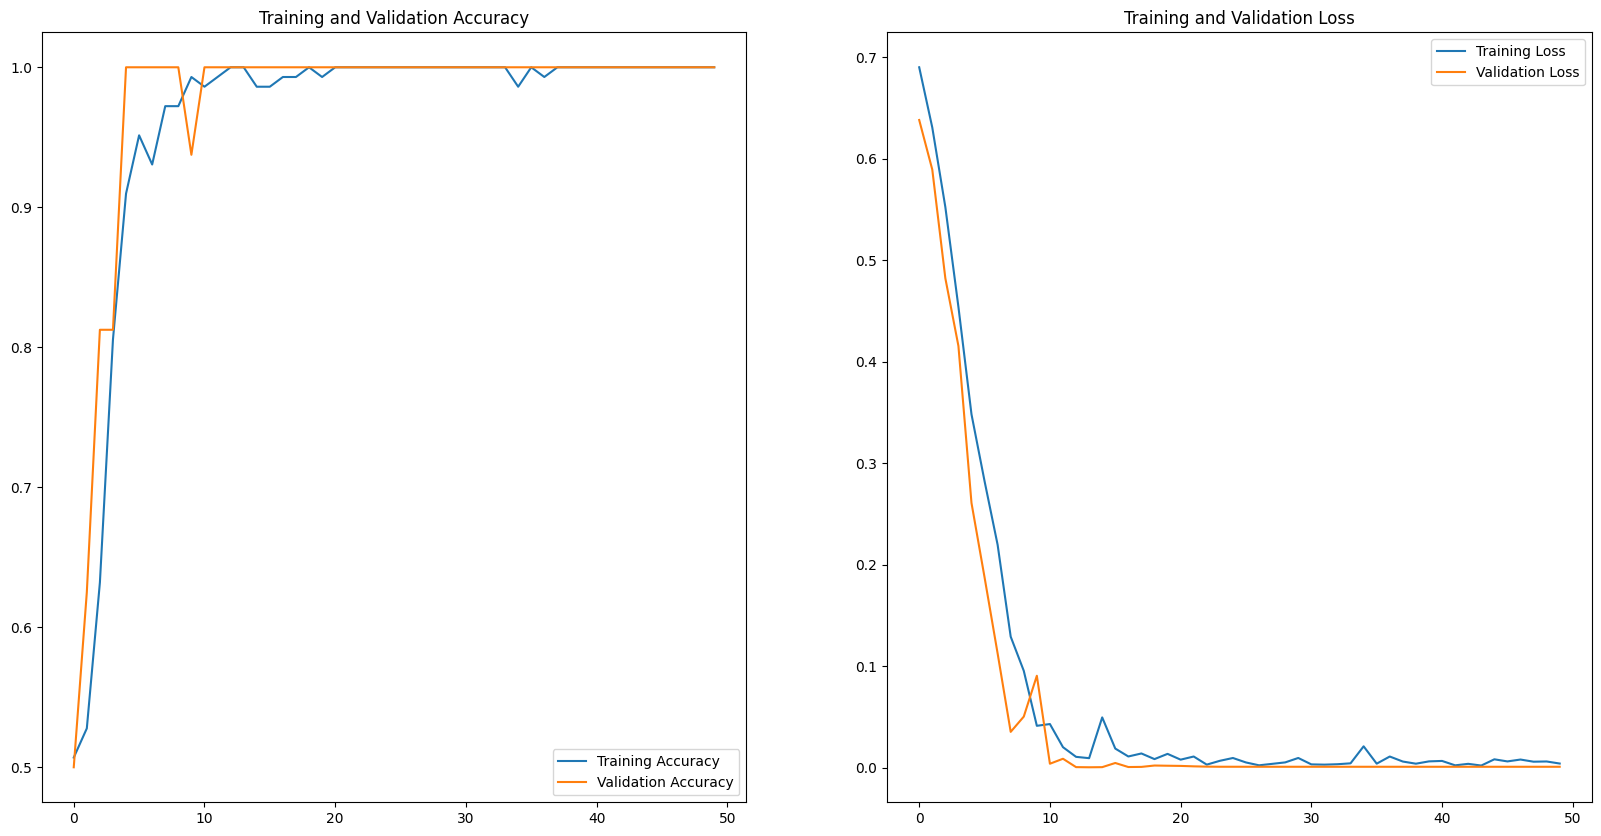

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = history.epoch

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# 8. Make Predictions

In [29]:
res = model.predict(X_test)

1/1 [==============================] - 1s 555ms/step


In [30]:
actions[np.argmax(res[11])]

'Bapak'

In [31]:
actions[np.argmax(y_test[11])]

'Bapak'

# 9. Save Weights

In [32]:
model.save('model_13classes_261021.h5')

c:\Streamlit\dims\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
